In [1]:
import os
os.getcwd()

'c:\\Users\\Acer\\Desktop\\Projekt'

Łączenie pliku csv z API ze strony geoapify

In [ ]:
import pandas as pd
import requests
import time

API_KEY = "Nie pokazany w celach bezpeczeństwa"
request_count = 0
limit_warning_printed = False
MAX_WARN = 2950

def check_limit():
    global request_count, limit_warning_printed
    if request_count >= MAX_WARN and not limit_warning_printed:
        print(f"Uwaga: przekroczono {MAX_WARN} zapytań API.")
        limit_warning_printed = True

def get_coordinates(district, street, api_key):
    global request_count
    address = f"{street}, {district}, Warszawa, Polska"
    url = f"https://api.geoapify.com/v1/geocode/search?text={address}&format=json&apiKey={api_key}"
    response = requests.get(url)
    request_count += 1
    check_limit()
    if response.ok:
        data = response.json()
        if data['results']:
            coords = data['results'][0]
            return coords['lat'], coords['lon']
    return None, None

def count_places(lat, lon, category, radius=500, api_key=None):
    global request_count
    url = (
        f"https://api.geoapify.com/v2/places?categories={category}"
        f"&filter=circle:{lon},{lat},{radius}&limit=50&apiKey={api_key}"
    )
    response = requests.get(url)
    request_count += 1
    check_limit()
    if response.ok:
        return len(response.json().get("features", []))
    return 0

df = pd.read_csv("warszawa_mieszkania.csv")

# Nowe kolumny
df["latitude"] = None
df["longitude"] = None
df["num_schools"] = 0
df["num_bus_stops"] = 0
df["num_supermarkets"] = 0

# Uzupelnij danych
for idx, row in df.iterrows():
    lat, lon = get_coordinates(row["dzielnica"], row["ulica"], API_KEY)
    if lat and lon:
        df.at[idx, "latitude"] = lat
        df.at[idx, "longitude"] = lon
        df.at[idx, "num_schools"] = count_places(lat, lon, "education.school", api_key=API_KEY)
        df.at[idx, "num_bus_stops"] = count_places(lat, lon, "public_transport.bus", api_key=API_KEY)
        df.at[idx, "num_supermarkets"] = count_places(lat, lon, "commercial.supermarket", api_key=API_KEY)
    else:
        print("Nie znaleziono wspolrzednych.")
    time.sleep(1.2)


df.to_csv("ogloszenia_plus.csv", index=False)
print("Kompilacja zakonczona.")


Kompilacja zakonczona.


Do wykoniania połączenia łączącego csv z API - użyto 2,685(Number of requests) oraz 2,740(Cost in Credits) ze strony geoapify, dla każdego wiersza wykonuja się 4 zapytania

Czyszczenie danych etc.

In [4]:
import pandas as pd

df = pd.read_csv("ogloszenia_plus.csv")
df.head()

,miasto,dzielnica,ulica,powierzchnia_m2,liczba_pokoi,pietro,cena_wynajmu,latitude,longitude,num_schools,num_bus_stops,num_supermarkets
0,Warszawa,Mokotów,Marszałkowska 141,59.93,2,3,4832,52.222945,21.016220,12,20,2
1,Warszawa,Bemowo,Puławska 217,62.95,4,0,4181,52.177950,21.021506,1,20,4
2,Warszawa,Bemowo,Kampinoska 14,45.32,2,8,3592,52.275110,20.902868,0,2,0
3,Warszawa,Bemowo,Wolska 113,81.58,3,7,7462,52.229708,20.953238,3,17,2
4,Warszawa,Śródmieście,Aleje Jerozolimskie 217,40.61,3,5,2896,54.350204,18.654309,2,8,2


Czyszczenie danych

In [5]:
df_clean = df.dropna()
df_clean = df_clean.drop(columns=['ulica', 'miasto'], errors='ignore')
df_clean = df_clean[(df_clean["cena_wynajmu"] > 500) & (df_clean["cena_wynajmu"] < 20000)]

assert df_clean.isnull().sum().sum() == 0
assert (df_clean['powierzchnia_m2'] > 0).all()

df_clean.head()


,dzielnica,powierzchnia_m2,liczba_pokoi,pietro,cena_wynajmu,latitude,longitude,num_schools,num_bus_stops,num_supermarkets
0,Mokotów,59.93,2,3,4832,52.222945,21.016220,12,20,2
1,Bemowo,62.95,4,0,4181,52.177950,21.021506,1,20,4
2,Bemowo,45.32,2,8,3592,52.275110,20.902868,0,2,0
3,Bemowo,81.58,3,7,7462,52.229708,20.953238,3,17,2
4,Śródmieście,40.61,3,5,2896,54.350204,18.654309,2,8,2


Zapis/odczyt pliku Parquet

In [6]:
def save_to_parquet(df, filename='dane.parquet'):
    df.to_parquet(filename)

save_to_parquet(df_clean)

In [7]:
df2 = pd.read_parquet('dane.parquet')
df2.head()

,dzielnica,powierzchnia_m2,liczba_pokoi,pietro,cena_wynajmu,latitude,longitude,num_schools,num_bus_stops,num_supermarkets
0,Mokotów,59.93,2,3,4832,52.222945,21.016220,12,20,2
1,Bemowo,62.95,4,0,4181,52.177950,21.021506,1,20,4
2,Bemowo,45.32,2,8,3592,52.275110,20.902868,0,2,0
3,Bemowo,81.58,3,7,7462,52.229708,20.953238,3,17,2
4,Śródmieście,40.61,3,5,2896,54.350204,18.654309,2,8,2


In [8]:
df_encoded = pd.get_dummies(df_clean, columns=["dzielnica"], drop_first=True)
df_encoded.head()

,powierzchnia_m2,liczba_pokoi,pietro,cena_wynajmu,latitude,longitude,num_schools,num_bus_stops,num_supermarkets,dzielnica_Bielany,dzielnica_Mokotów,dzielnica_Ochota,dzielnica_Praga-Południe,dzielnica_Targówek,dzielnica_Ursynów,dzielnica_Wola,dzielnica_Śródmieście,dzielnica_Żoliborz
0,59.93,2,3,4832,52.222945,21.016220,12,20,2,False,True,False,False,False,False,False,False,False
1,62.95,4,0,4181,52.177950,21.021506,1,20,4,False,False,False,False,False,False,False,False,False
2,45.32,2,8,3592,52.275110,20.902868,0,2,0,False,False,False,False,False,False,False,False,False
3,81.58,3,7,7462,52.229708,20.953238,3,17,2,False,False,False,False,False,False,False,False,False
4,40.61,3,5,2896,54.350204,18.654309,2,8,2,False,False,False,False,False,False,False,True,False


In [9]:
X = df_encoded.drop(columns=["cena_wynajmu"])
y = df_encoded["cena_wynajmu"]

Standaryzacja/Podział danych na treningowe i testowe

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
num_cols = ["powierzchnia_m2", "liczba_pokoi", "pietro",
            "num_schools", "num_bus_stops", "num_supermarkets",
            "latitude", "longitude"]

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


print(f"Treningowe: {X_train.shape}, Testowe: {X_test.shape}")


Treningowe: (560, 17), Testowe: (140, 17)


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['log2', 'sqrt']
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=50, cv=5,
    scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)

Best params: {'max_depth': 38, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 444}


Random Forest Regressor

In [12]:
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

best_params = random_search.best_params_

rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
rmse = root_mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest (best tuned) - MAE: {mae:.2f}")
print(f"Random Forest (best tuned) - RMSE: {rmse:.2f}")
print(f"Random Forest (best tuned) - R²: {r2:.4f}")

Random Forest (best tuned) - MAE: 524.00
Random Forest (best tuned) - RMSE: 682.29
Random Forest (best tuned) - R²: 0.8400


XGBoost Regressor

In [13]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost - MAE:", mae_xgb)
print("XGBoost - RMSE:", rmse_xgb)
print("XGBoost - R²:", r2_xgb)

XGBoost - MAE: 526.848015485491
XGBoost - RMSE: 661.7461813311916
XGBoost - R²: 0.8494735956192017


Regresja liniowa

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression - MAE:", mae_lr)
print("Linear Regression - RMSE:", rmse_lr)
print("Linear Regression - R²:", r2_lr)

Linear Regression - MAE: 406.637465756908
Linear Regression - RMSE: 512.1895129006451
Linear Regression - R²: 0.9098239490559257


In [15]:
results = {
    "Model": ["Random Forest", "XGBoost", "Linear Regression"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_xgb),
        mean_absolute_error(y_test, y_pred_lr),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    ],
    "R²": [
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_xgb),
        r2_score(y_test, y_pred_lr),
    ]
}

pd.DataFrame(results)

,Model,MAE,RMSE,R²
0,Random Forest,523.997378,682.293564,0.839981
1,XGBoost,526.848015,661.746181,0.849474
2,Linear Regression,406.637466,512.189513,0.909824


Wizualizacja wyników

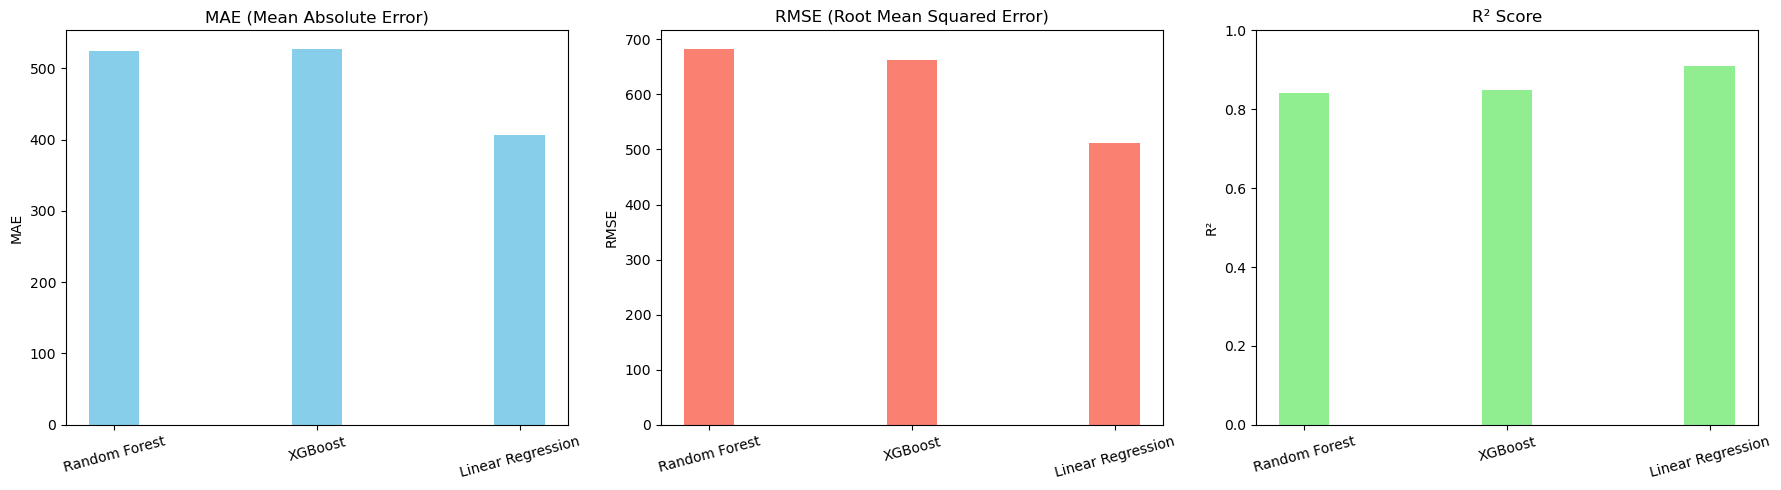

In [16]:
import matplotlib.pyplot as plt

model_names = ["Random Forest", "XGBoost", "Linear Regression"]

mae_scores = [523.997378, 526.848015, 406.637466]
rmse_scores = [682.293564, 661.746181, 512.189513]
r2_scores = [0.839981, 0.849474, 0.909824]

x = np.arange(len(model_names))  
width = 0.25 

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# MAE
axs[0].bar(x, mae_scores, color='skyblue', width=width)
axs[0].set_title("MAE (Mean Absolute Error)")
axs[0].set_ylabel("MAE")
axs[0].set_xticks(x)
axs[0].set_xticklabels(model_names, rotation=15)

# RMSE
axs[1].bar(x, rmse_scores, color='salmon', width=width)
axs[1].set_title("RMSE (Root Mean Squared Error)")
axs[1].set_ylabel("RMSE")
axs[1].set_xticks(x)
axs[1].set_xticklabels(model_names, rotation=15)

# R²
axs[2].bar(x, r2_scores, color='lightgreen', width=width)
axs[2].set_title("R² Score")
axs[2].set_ylabel("R²")
axs[2].set_xticks(x)
axs[2].set_xticklabels(model_names, rotation=15)
axs[2].set_ylim([0, 1])

plt.tight_layout()
plt.show()


Przewidywane vs. Rzeczywiste ceny

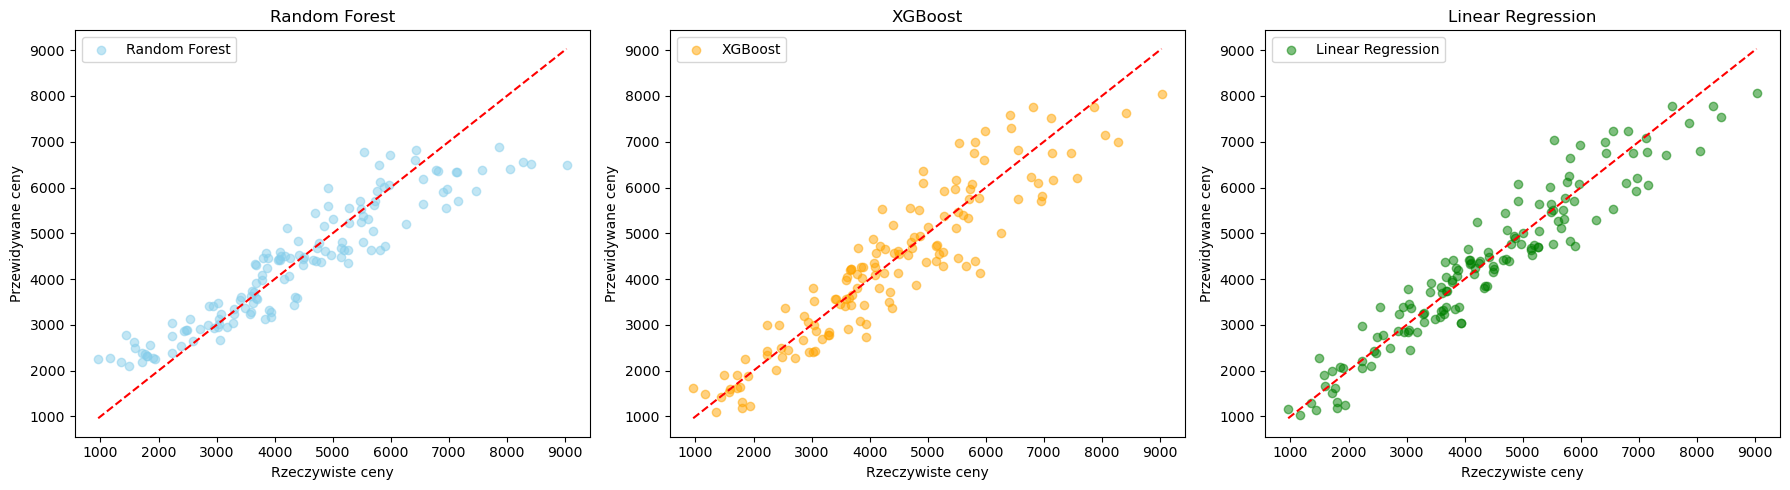

In [17]:
plt.figure(figsize=(18, 5))

# Random Forest
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='skyblue', label="Random Forest")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Rzeczywiste ceny")
plt.ylabel("Przewidywane ceny")
plt.title("Random Forest")
plt.legend()

# XGBoost
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='orange', label="XGBoost")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Rzeczywiste ceny")
plt.ylabel("Przewidywane ceny")
plt.title("XGBoost")
plt.legend()

# Regresji Liniowej
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_lr, alpha=0.5, color='green', label="Linear Regression")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Rzeczywiste ceny")
plt.ylabel("Przewidywane ceny")
plt.title("Linear Regression")
plt.legend()

plt.tight_layout()
plt.show()
